### COMP90024 Clauster and Cloud Computering Assignment 2 - Group 46

**Please run this jupyter notebook on a browser**. The vscode or pychram doesn't support to display controls in ipywidgets.

You need to import following **Python** libraries. And You need to put the `pop_crime.py` and `traffic_crash.py` in the same directory with this jupyter notebook.

**Note:** We are the team that is impacted by the MRC issue. So the clusters are unstable, and the execution of RestFul API sometimes takes a long time.

In [5]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from pop_crime import Pop_crime
import folium
import matplotlib.pyplot as plt
import requests
import json
import numpy as np
pop_crime = Pop_crime()
from traffic_crash import road_crash
road_crash = road_crash()
from ipywidgets import Dropdown, Output, HBox
from IPython.display import display
import ast
from shapely.geometry import Point,MultiPolygon
from requests.exceptions import JSONDecodeError

### The Cities that are able to be analyzed in this prject

We choose three cites (Melbourne, Geelong and Ballarat) in VIC.

In [6]:
city_dic = {'Melbourne': [-37.81, 144.96], "Geelong" :[-38.15, 144.36], "Ballarat": [-37.56, 143.85]}

#### Please select the city !

For a valid analyzing target, you should choose one city in **Melbourne**, **Geelong** and **Ballarat**.

- Type in the city name in the blank box
- Press 'Enter'
- Execute the next code cell. (Do not repeat this cell).

In [7]:
city_list = "Melbourne, Geelong, Ballarat"
while True:
    user_input = input("Please choose city from " + city_list)
    if user_input in ["Melbourne", "Geelong", "Ballarat"]:
        print(f"The city you selected is : {user_input}")
        break
    else:
        print("Incorrect input, please choose city from" + city_list)

city = user_input

Please choose city from Melbourne, Geelong, Ballarat Melbourne


The city you selected is : Melbourne


#### Load datasets from the selected city !

##### Loading the traffic volume and road crashes in this city now !
It loads the current city's geographic information for drawing. Since every street in the city is searched, it will take a litte longer time.

In [8]:
# download roads and crash data
try:
    response_r = requests.get("http://127.0.0.1:9090/traffic_volume/"+ city)
    response_c = requests.get("http://127.0.0.1:9090/vic_roads_crash/" + city)
    road_source = response_r.json()
    crash_source = response_c.json()
except JSONDecodeError:
    print("becaues of Cinder issue, the fission loses connection. \nPlease Try Again.")

##### Loading the distributions of population and offence accidents in this city now !

In [9]:
# download population and offence data
try:
    response_p_o = requests.get("http://127.0.0.1:9090/population/crime/city/"+ city)
    pop_source = response_p_o.json()['population']
    crime_source = response_p_o.json()['crime']
    pop_cr_source = response_p_o.json()['pop_cr']
    select_source = response_p_o.json()['selected_rows']
    geo_source =response_p_o.json()['crime_geo']
except JSONDecodeError:
    print("becaues of Cinder issue, the fission loses connection. \nPlease Try Again.")

In [10]:
roads_df1 = pd.DataFrame(road_source)
crash_df1 = pd.DataFrame(crash_source)
pop_df1 = pd.DataFrame(json.loads(pop_source))
crime_df1 = pd.DataFrame(json.loads(crime_source))
pop_cr = pd.DataFrame(json.loads(pop_cr_source))
selected_rows = pd.DataFrame(json.loads(select_source))
crime_geo = pd.DataFrame(json.loads(geo_source))
fea = pop_crime.object_to_geojson(selected_rows, 'geometry', 'LGA_name')
red, yellow, green, blue = road_crash.get_roads_list(roads_df1)
red = road_crash.drop_list(red)
yellow = road_crash.drop_list(yellow)
green = road_crash.drop_list(green)
blue = road_crash.drop_list(blue)
red_crash, yellow_crash, green_crash, blue_crash = road_crash.check_crash_num(crash_df1, red, yellow, green, blue)

##### Loading the the anaysis information of Wind Speed and Air Quality

In [11]:
try:
    response_b_w = requests.get("http://127.0.0.1:9090/windspeed/pollution/analysis")
    bom_source = response_b_w.json()['bom']
    epa_source = response_b_w.json()['epa']
except JSONDecodeError:
    print("becaues of Cinder issue, the fission loses connection. \nPlease Try Again.")

In [12]:
bom_df = pd.DataFrame(bom_source)
bom_df = pop_crime.preprocessing_bom(bom_df, selected_rows)
epa_df = pd.DataFrame(epa_source)
epa_df = pop_crime.preprocessing_epa(epa_df)

##### Notice that the matching process may take about 1 minute

This is where we match weather and air quality data with our road geographic information

In [13]:
bom_df = pop_crime.find_nearest_station(epa_df, bom_df)

#### Show traffic volume data distribution. 
- `Count` Shows How many streets are calculated.
- `xx%` quantile Shows the value below which `xx%` of the data falls, indicating the lower end of the traffic volume distribution.

In [14]:
feature_collection = pop_crime.object_to_geojson(bom_df, 'geometry', 'STATION')
roads_df1['ALLVEHS_MMW'].describe()

count      2741.000000
mean      13685.321051
std       15965.242804
min         138.000000
25%        5900.000000
50%        9100.000000
75%       15000.000000
max      132000.000000
Name: ALLVEHS_MMW, dtype: float64

### Traffic Volume VS. Crash Counts

You can freely zoom, pan, and click on maps. After clicking on a event on the map, you can see the degree of injury.

In [15]:
map = folium.Map(location = city_dic[city], titles = "traffic volume and crash", zoom_start= 11)
road_crash.draw_map(roads_df1, map)
road_crash.add_point(crash_df1, map)
map

#### The Pie Chart for Traffic Volume vs. Crash Counts
- **Example**: **Red Color** -> $61.8\%$(in Melbourne) of total accidents happened on road where its traffic volume over $11000$

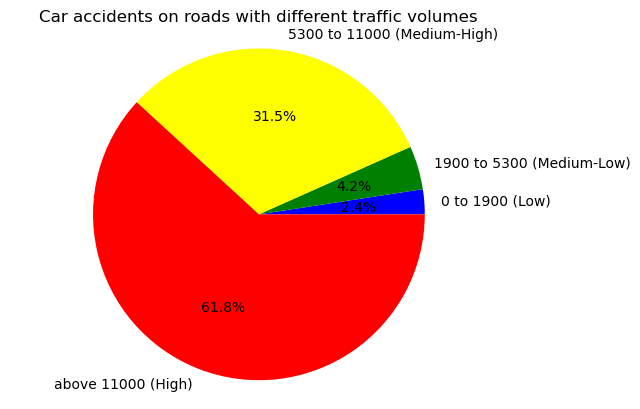

In [16]:
categories = ['0 to 1900 (Low)', '1900 to 5300 (Medium-Low)', '5300 to 11000 (Medium-High)', 'above 11000 (High)']
values = [blue_crash, green_crash, yellow_crash, red_crash]
title = 'Car accidents on roads with different traffic volumes'
road_crash.plot_pie_chart(categories, values, title)

#### Traffic Volume VS. Counts of Different Crash Type

You can select different types of crashes in the **drop down box** below

If you see an error called "500", it says we lose the connection to Fission due to Cinder error.

If you see an error called "Error displaying widget: model not found", please re-run this cell. Because the jupyter cannot load historical results.

In [17]:
acc_list = ["choose accident type", "Collision with a fixed object", "Collision with vehicle", "Vehicle overturned (no collision)", "collision with some other object", "Struck Pedestrian", "No collision and no object struck", "Struck animal", "Fall from or in moving vehicle", "Other accident"]
road_crash.show_crashtype(acc_list)

Output()

####  Traffic Volume VS. Pollutant Concentration
If you see an error called "500", it says we lose the connection to Fission due to Cinder error.

If you see an error called "Error displaying widget: model not found", please re-run this cell. Because the jupyter cannot load historical results.

In [18]:
pol_list = ["choosee pollutant type", "PM2.5", "Particles", "PM10", "O3", "SO2", "NO2"]
road_crash.show_pol(pol_list)

Output()

#### Wind Speed VS. PM2.5 or Particles

You can freely zoom, pan, and click on maps. After clicking the button on the right-top corner, you can change the layer to see different Pollutants.

In [19]:
m_po_wind = pop_crime.draw_mpowind(city_dic[city], feature_collection, bom_df)
pop_crime.add_layer(bom_df, 'PM2.5', 'red', m_po_wind, True)
pop_crime.add_layer(bom_df, 'Particles', 'green', m_po_wind, False)
folium.LayerControl().add_to(m_po_wind)
m_po_wind

##### Show the correlations between Wind Speed and Air Pollutants

- **positive correlation**: the value will be greater than 0
- **negative correlation**: the value will be less than 0

In [20]:
print("PM2.5 with wind speed : correlation is", np.corrcoef(bom_df['wind_spd_kmh'], bom_df['PM2.5'])[0][1])
print("Particles with wind speed : correlation is", np.corrcoef(bom_df['wind_spd_kmh'], bom_df['Particles'])[0][1])

PM2.5 with wind speed : correlation is 0.3376007404796701
Particles with wind speed : correlation is 0.46072384291915713


### Crime VS. Population

You can freely zoom, pan, and click on maps. 
- The darker the map, the hiher the population density.
- The larger the circle, the more the crimes.

In [21]:
m_pop = pop_crime.draw_pmap(city_dic[city], fea, selected_rows, crime_geo)
m_pop

#### Populations VS. Offence Counts

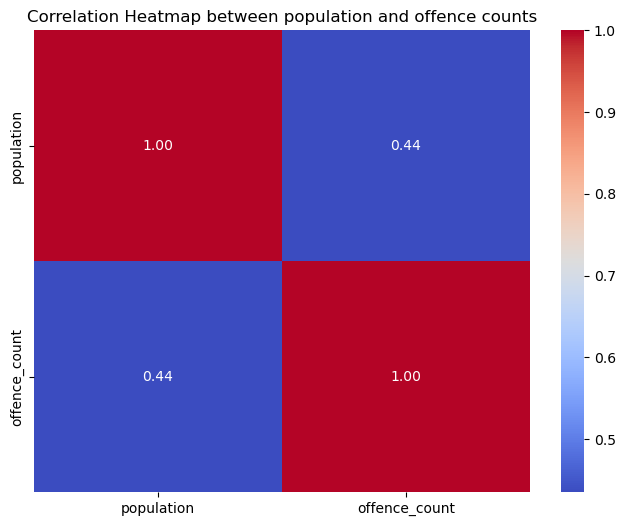

In [22]:
# correlation between population and offence_count
correlation_matrix = pop_cr[["population", "offence_count"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between population and offence counts')
plt.show()

#### Different Kinds of Crime VS. Population

If you see an error called "Error displaying widget: model not found", please re-run this cell. Because the jupyter cannot load historical results.

In [23]:
type_crime = pop_crime.merge_df(pop_df1, crime_df1)
crime_list= sorted(list(set(type_crime["offence_subdiv"])))
crime_list.insert(0, 'choose offences type')
crime_pear = {'types': crime_list[1:], 'pearson':[]}
crime_pear = pop_crime.crime_pears(crime_list, type_crime, crime_pear)
pop_crime.show_offence(crime_list, type_crime)

Output()

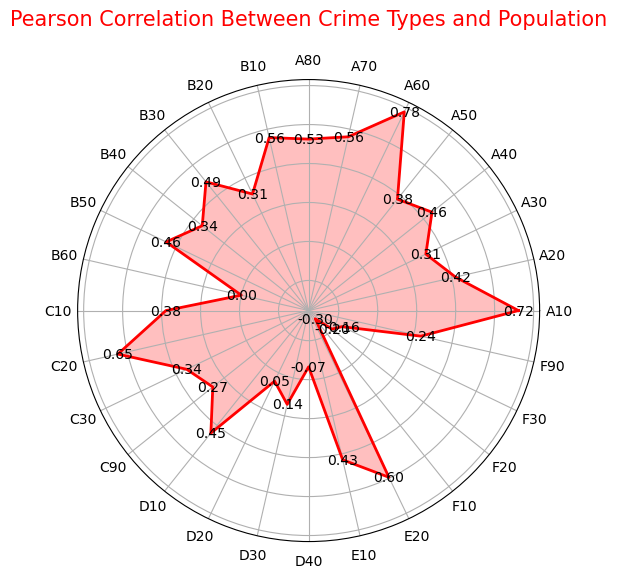

In [24]:
pop_crime.draw_radar(crime_pear)

### Public Sentiments Analysis

#### Loading Sentiments for Crashes

In [25]:
try:
    response_ma_crash = requests.get("http://127.0.0.1:9090/data/mastodon/crash")
    ma_crash_source = response_ma_crash.json()
except JSONDecodeError:
    print("becaues of Cinder issue, the fission loses connection. \nPlease Try Again.")

#### Loading Public Sentiments from AU server

In [26]:
try:
    response_ma_bom = requests.get("http://127.0.0.1:9090/data/mastodon/bom")
    ma_bom_source = response_ma_bom.json()
except JSONDecodeError:
    print("becaues of Cinder issue, the fission loses connection. \nPlease Try Again.")

#### Loading Weather Conditions from BoM

In [27]:
try:
    response_ma_ = requests.get("http://127.0.0.1:9090/data/weather/bom")
    ma_inbom_source = response_ma_.json()
except JSONDecodeError:
    print("becaues of Cinder issue, the fission loses connection. \nPlease Try Again.")

#### Loading Sentiments for Crimes

In [28]:
try:
    response_ma_crime = requests.get("http://127.0.0.1:9090/data/mastodon/crime")
    crime_bom_source = response_ma_crime.json()
except JSONDecodeError:
    print("becaues of Cinder issue, the fission loses connection. \nPlease Try Again.")

In [29]:
df_bom = pd.DataFrame(ma_inbom_source)
df_mastodon = pd.DataFrame(ma_bom_source)

df_bom.rename(columns={'DATE': 'created_at'}, inplace=True)

df_bom['created_at'] = pd.to_datetime(df_bom['created_at'])
df_mastodon['created_at'] = pd.to_datetime(df_mastodon['created_at'])

merged_df = pd.merge(df_bom, df_mastodon, on='created_at', how='inner')
merged_df['rain_trace'] = pd.to_numeric(merged_df['rain_trace'], errors='coerce')
merged_df = merged_df.dropna(subset=['rain_trace'])
merged_df = pop_crime.get_masto(ma_inbom_source, ma_bom_source)
def draw_mastpie(dataframe):
    greater_than_5 = dataframe[dataframe['sentiment'] >= 5]
    less_than_5 = dataframe[dataframe['sentiment'] < 5]

    counts = [len(greater_than_5), len(less_than_5)]
    labels = ['Sentiment > 5', 'Sentiment < 5',]

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
    plt.title('Distribution of Contents by Sentiment', pad=20)
    plt.axis('equal')
    plt.show()

#### Pie Chart for Distribution of Different Sentiment levels

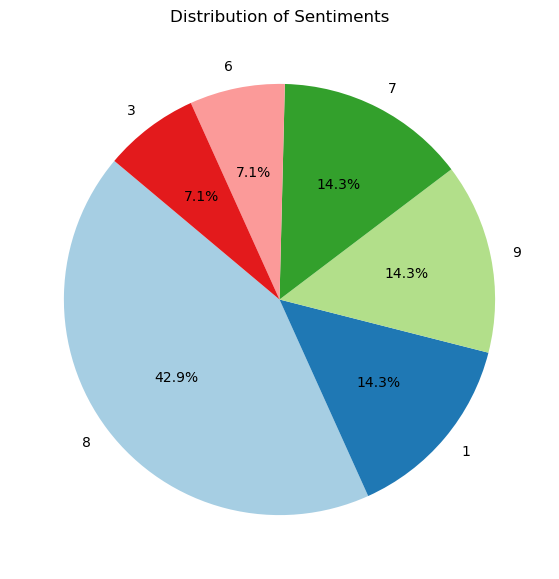

In [30]:
sentiment_bom = merged_df['sentiment'].value_counts()
sentiment_bom = sentiment_bom.drop(5)

fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(sentiment_bom, labels=sentiment_bom.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(np.arange(len(sentiment_bom))))
ax.set_title('Distribution of Sentiments')

plt.show()

#### Bar Chart to show distribution of sentiments under different weather conditions

You can select different types of crashes in the **drop down box** below

In [31]:
pop_crime.draw_mastbom(merged_df)

Output()

#### Distribution of Unneutral Mastodon Data on Different Topics



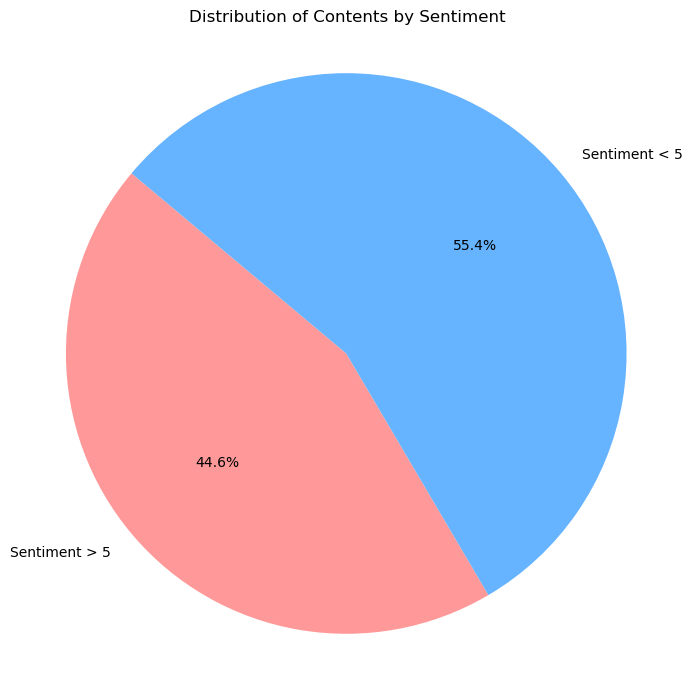

In [32]:
crash_mast = pd.DataFrame(ma_crash_source)
sentiment_crash = crash_mast['sentiment'].value_counts().sort_index()
plt.close()
pop_crime.draw_mastpie(crash_mast)

#### mastodon of crime

In [33]:
plt.close()
crime_mast = pd.DataFrame(crime_bom_source)
sentiment_counts = crime_mast['sentiment'].value_counts().sort_index()

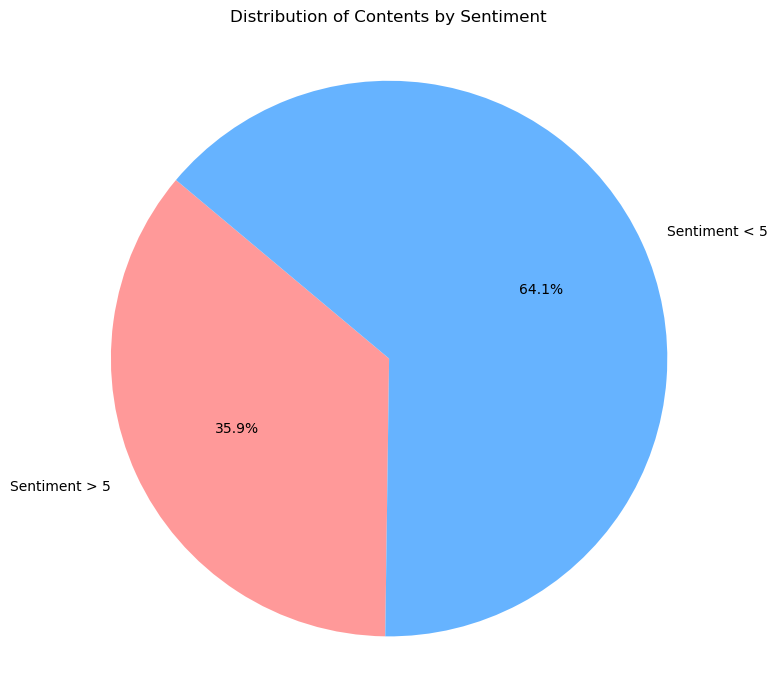

In [34]:
plt.close()
pop_crime.draw_mastpie(crime_mast)